# [GN-2] News Multi-Classification  

이번 프로젝트의 목표는 
1. Vocabulary Size가 성능에 미치는 영향을 파악   
    - 너무 많은 단어장을 사용하면 성능저하가 되고, 너무 적은 단어장은 UNKNOWN단어가 많이 포함되 성능저하가 되므로 어느 정도의 단어수가 성능에 최대화 시킬 수 있는지 탐색하자.   
<br>
2. 다양한 머신러닝 모델 적용
    - 8가지 머신 러닝 모델들에 적용하여 성능지표를 확인해보고, 알고리즘 특성에 따라 원인을 분석해보자.   
<br>    
3. Deep Learning 모델 적용
    - 동일 조건으로 딥러닝을 적용해보자. 

In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn 
from tensorflow.keras.datasets import reuters
import warnings
warnings.filterwarnings(action='ignore')

print(tf.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.9.0
3.7.1
0.12.2
1.23.5
2.0.1
1.2.1


In [2]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from tqdm import tqdm

# 1.Data 탐색

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


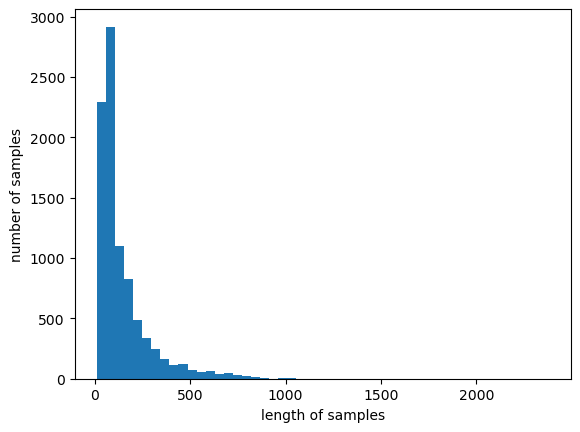

In [4]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

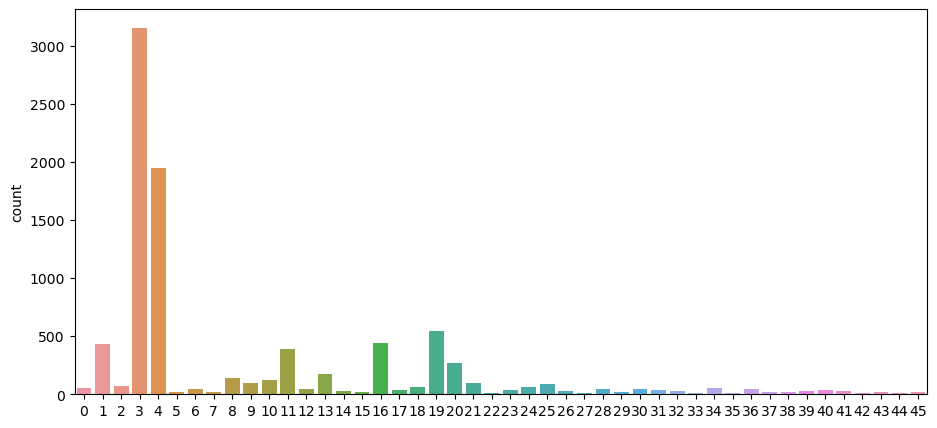

In [5]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

📑class는 모두 46개 이고, 3고가 4에 대부분의 데이타가 몰려있는 불균형한 데이타(imbalanced data)라고 할 수있다. 

In [6]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


📑3번 3159 개,  4번 1949 데이타가 존재한다. 16(444), 19(549) 갯수가 존재한다.   

In [7]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
word_index['the'],word_index['it']

(1, 13)

In [8]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [9]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

📑 \<pad>, \<sos>, \<unk> 토큰을 인덱스 추가해준다.

In [10]:
index_to_word[4],index_to_word[16]

('the', 'it')

In [11]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [12]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [13]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

# 2.공통함수 만들기

## 2.1 Data load

In [14]:

def data_load(num_words):

    # 1. num_words 수만큼 데이타 load
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    word_index = reuters.get_word_index(path="reuters_word_index.json")
    index_to_word = { index+3 : word for word, index in word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
        
    decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded.append(t)
    x_train = decoded

    decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded.append(t)
    x_test = decoded

    dtmvector = CountVectorizer()
    tfidf_transformer = TfidfTransformer()

    # 2. Train Data => DTM => TF-IDF 변환

    x_train_dtm = dtmvector.fit_transform(x_train)
    tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)

    # 3. Test Data => DTM => TF-IDF 변환

    x_test_dtm = dtmvector.transform(x_test) 
    tfidfv_test = tfidf_transformer.transform(x_test_dtm) 

    return_data = {}
    return_data['X_train'] = tfidfv_train
    return_data['y_train'] = y_train
    return_data['X_test'] = tfidfv_test
    return_data['y_test'] = y_test
        
    return return_data

## 2.2 performance_metrics

In [15]:

def performance_metrics(model_name, y, y_pred, y_pred_proba):
    metrics={}
    metrics['model']=model_name
    metrics['accuracy'] = accuracy_score(y, y_pred)
    metrics['f1'] = f1_score(y, y_pred, average='macro')
    metrics['precision'] = precision_score(y, y_pred, average='macro', zero_division=1)
    metrics['recall'] = recall_score(y, y_pred, average='macro', zero_division=1)
    metrics['roc_auc'] = roc_auc_score(y, y_pred_proba, multi_class='ovr')
    metrics['report'] = classification_report(y, y_pred, output_dict=True)
    metrics['cm'] = confusion_matrix(y, y_pred)
    
    return metrics

## 2.3 model train

In [16]:

def model_train(models, data):
        
        df = pd.DataFrame(columns=['model', 'accuracy', 'f1', 'precision', 'recall', 'roc_auc','report','cm'])
        X_train = data['X_train']
        y_train = data['y_train']
        X_test = data['X_test']
        y_test = data['y_test']
        
        for model_name, model in models.items():
                for i in tqdm(range(1)):
                        print(model_name + ' started...')
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        if model_name =='LinearSVC':
                                y_pred_proba=model._predict_proba_lr(X_test)
                        else:
                                y_pred_proba=model.predict_proba(X_test)
                        
                        metrics = performance_metrics(model_name, y_test, y_pred, y_pred_proba)
                        df.loc[len(df)] = metrics
                        
                        
        return df

In [17]:
models = {'MultinomialNB': MultinomialNB(),
              'LogisticRegression': LogisticRegression(C=10000, penalty='l2', max_iter=3000),
              'ComplementNB': ComplementNB(),
              'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=0),
              'RandomForest': RandomForestClassifier(n_estimators=5, random_state=0),
              'GradientBoosting': GradientBoostingClassifier(random_state=0),
              'Voting': VotingClassifier(estimators=[
                                   ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
                                   ('cb', ComplementNB()),
                                   ('grbt', GradientBoostingClassifier(random_state=0))
                            ], voting='soft'),
              'LinearSVC': LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
       }


# 3.Vocabulary size별 데이타 생성

## 3.1 모든 단어 사용

In [18]:
import os
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [19]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:

tfidfv_data_all = data_load(num_words=None)
with tf.device('/GPU:0'):
    m = model_train(models, tfidfv_data_all)
    m['words'] = 'all'
    m['order'] = 100
    df = pd.DataFrame(m)

100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


MultinomialNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

LogisticRegression started...


100%|██████████| 1/1 [00:00<00:00,  7.81it/s]


ComplementNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

DecisionTree started...


  0%|          | 0/1 [00:00<?, ?it/s]

RandomForest started...


  0%|          | 0/1 [00:00<?, ?it/s]

GradientBoosting started...


  0%|          | 0/1 [00:00<?, ?it/s]

Voting started...


  0%|          | 0/1 [00:00<?, ?it/s]

LinearSVC started...


100%|██████████| 1/1 [01:01<00:00, 61.94s/it]


In [21]:
df.head()

,model,accuracy,f1,precision,recall,roc_auc,report,cm,words,order
0,MultinomialNB,0.599733,0.067679,0.961565,0.068328,0.872576,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...","[[0, 0, 0, 2, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",all,100
1,LogisticRegression,0.816118,0.668569,0.785437,0.635221,0.967902,"{'0': {'precision': 0.8888888888888888, 'recal...","[[8, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",all,100
2,ComplementNB,0.764915,0.463985,0.835864,0.416823,0.971693,"{'0': {'precision': 0.8571428571428571, 'recal...","[[6, 3, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",all,100
3,DecisionTree,0.621104,0.154501,0.698264,0.145197,0.801507,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...","[[0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0...",all,100
4,RandomForest,0.654497,0.279463,0.594338,0.252052,0.724997,"{'0': {'precision': 0.25, 'recall': 0.58333333...","[[7, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",all,100


## 3.2 빈도수 상위 5,000개의 단어만 사용

In [22]:

tfidfv_data_5k = data_load(num_words=5000)
m = model_train(models, tfidfv_data_5k)
m['words'] = '5k'
m['order'] = 5
df = pd.concat([df, m], axis=0)

100%|██████████| 1/1 [00:00<00:00, 13.16it/s]


MultinomialNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

LogisticRegression started...


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


ComplementNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

DecisionTree started...


  0%|          | 0/1 [00:00<?, ?it/s]

RandomForest started...


  0%|          | 0/1 [00:00<?, ?it/s]

GradientBoosting started...


  0%|          | 0/1 [00:00<?, ?it/s]

Voting started...


  0%|          | 0/1 [00:00<?, ?it/s]

LinearSVC started...


100%|██████████| 1/1 [01:19<00:00, 79.06s/it]


## 3.3 빈도수 상위 10000 단어 사용

In [23]:

tfidfv_data_10k = data_load(num_words=10000)
m = model_train(models, tfidfv_data_10k)
m['words'] = '10k'
m['order'] = 10
df = pd.concat([df, m], axis=0)

100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


MultinomialNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

LogisticRegression started...


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


ComplementNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

DecisionTree started...


  0%|          | 0/1 [00:00<?, ?it/s]

RandomForest started...


  0%|          | 0/1 [00:00<?, ?it/s]

GradientBoosting started...


  0%|          | 0/1 [00:00<?, ?it/s]

Voting started...


  0%|          | 0/1 [00:00<?, ?it/s]

LinearSVC started...


100%|██████████| 1/1 [01:03<00:00, 63.86s/it]


## 3.4 빈도수 상위 3000 단어 사용

In [24]:

tfidfv_data_3k = data_load(num_words=3000)
m = model_train(models, tfidfv_data_3k)
m['words'] = '3k'
m['order'] = 3
df = pd.concat([df, m], axis=0)

100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


MultinomialNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

LogisticRegression started...


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


ComplementNB started...


  0%|          | 0/1 [00:00<?, ?it/s]

DecisionTree started...


  0%|          | 0/1 [00:00<?, ?it/s]

RandomForest started...


  0%|          | 0/1 [00:00<?, ?it/s]

GradientBoosting started...


  0%|          | 0/1 [00:00<?, ?it/s]

Voting started...


  0%|          | 0/1 [00:00<?, ?it/s]

LinearSVC started...


100%|██████████| 1/1 [01:14<00:00, 74.62s/it]


In [25]:
# 정렬
df = df.sort_values(['order','model'])

In [26]:
# Metrics CSV파일로 저장
address = './'
df.to_csv(path_or_buf=address+'metrics.csv')

In [27]:
df.head()

,model,accuracy,f1,precision,recall,roc_auc,report,cm,words,order
2,ComplementNB,0.764470,0.442620,0.852377,0.412059,0.970844,"{'0': {'precision': 0.75, 'recall': 0.5, 'f1-s...","[[6, 3, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",3k,3
3,DecisionTree,0.626002,0.180503,0.709063,0.174756,0.813467,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...","[[0, 0, 0, 0, 10, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0...",3k,3
5,GradientBoosting,0.776046,0.577189,0.605354,0.572547,0.878198,"{'0': {'precision': 0.875, 'recall': 0.5833333...","[[7, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0,...",3k,3
7,LinearSVC,0.752004,0.584358,0.632640,0.579115,0.931367,"{'0': {'precision': 0.6363636363636364, 'recal...","[[7, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",3k,3
1,LogisticRegression,0.788068,0.650448,0.762185,0.604502,0.967779,"{'0': {'precision': 0.8888888888888888, 'recal...","[[8, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",3k,3


# 4.Visualization and Analysis


## 4.1 어떤 성능 지표를 기준으로 분석할 것인가? 

### 4.1 Accuracy by model for words (단어장에 대한 모델별 accuracy)

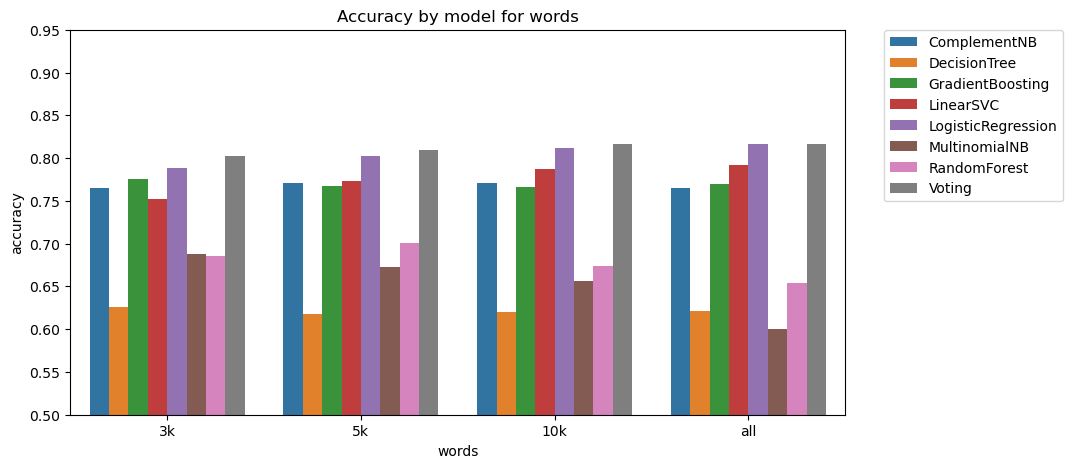

In [66]:
data_by_words_acc = df[['words','model','accuracy']]

plt.figure(figsize=(10, 5))
plt.title('Accuracy by model for words')
ax = sns.barplot(x='words', y='accuracy', hue='model', data=data_by_words_acc)
plt.ylim(0.5, 0.95)
# for p in ax.patches:
#     ax.annotate(f'{p.get_height():.3f}', (p.get_x()+p.get_width()/2.,\
#         p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

📑 Accuracy 기준으로 보면 
<font color='#838c84'>__Voting__ </font> > 
<font color='#7e6497'>__LogisticRegression__ </font> >
<font color='#c92509'>__LinearSVC__ </font> 순으로 성능이 좋다.

### 4.1 F1-score by model for words (단어장에 대한 모델별 f1-score)

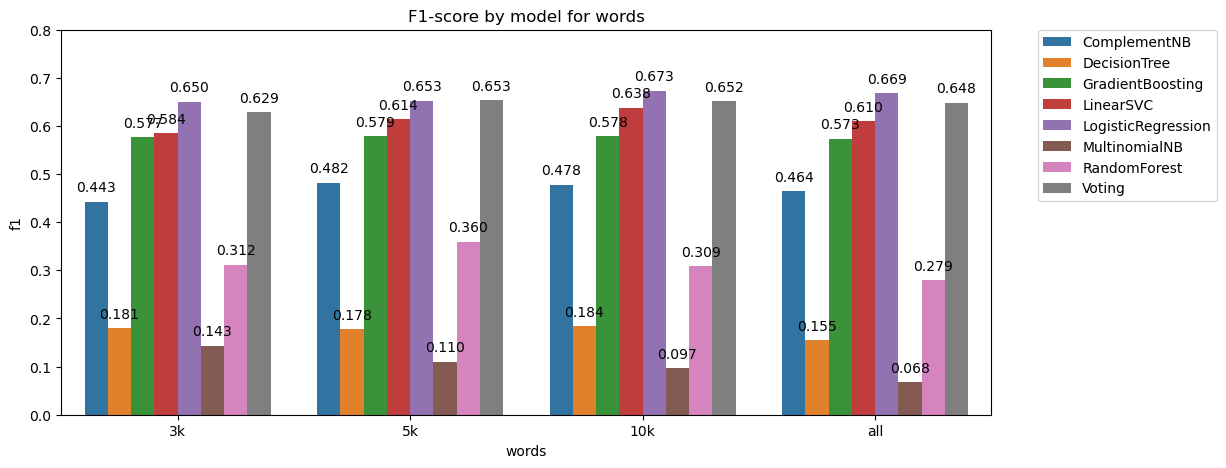

In [30]:
#단어장 크기별 성능 비교 - 단어장별, 모델별 f1-score
data_by_words_f1 = df[['words','model','f1']]

plt.figure(figsize=(12, 5))
plt.title('F1-score by model for words')
ax = sns.barplot(x='words', y='f1', hue='model', data=data_by_words_f1 )
plt.ylim(0.0, 0.8)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x()+p.get_width()/2.,\
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

📑 F1 score 기준으로 보면, 
<font color='#7e6497'>__LogisticRegression__ </font> >
<font color='#838c84'>__Voting__ </font> > 
<font color='#c92509'>__LinearSVC__ </font> 순으로 성능이 좋다.


- Accuracy 기준으로는 __`Voting`__ 이 더 좋지만, F1 score 기준으로는 __`LogisticRegression`__ 이 더 좋은 모델로 보인다. 
- 이와 같이 어떤  Metrics를 기준으로 평가하느냐에 따라 결과가 달라질 수 있다.
- 그러므로 Metrics 기준을 먼저 정하고 분석을 시작하는 것이 중요하다. 

- 클래스의 분포가 3, 4에 대부분의 데이타가 몰려있는 것을 감안하면 이 데이타는 불균형 데이타로 볼 수 있다. 
- 불균형 데이타에서 Accuracy는 정확도를 신뢰할 수 없기 때문이다.  
#### 🧐 결론적으로 Accuracy 보다는 `F1 score를 더 신뢰할 수 있는 지표`라 할 수 있겠다. 
- 글래스 불균형 데이타를 분석하는데 있어 Accuracy보다 더 신뢰할 만한 결과를 주기 때문이다. 

#### Performance Metrics
| 지표        | 특징                                                                       | 장점                                                                                   | 단점                                                                                                                               |
| --------- | ------------------------------------------------------------------------ | ------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------- |
| Accuracy  | \- 전체 예측 결과에서 올바르게 분류된 샘플의 비율<br>- 클래스 불균형 데이터셋에서는 사용하기 어려울 수 있음         | \- 직관적이고 이해하기 쉬움<br>- 클래스가 균형있게 분포된 데이터셋에서 유용                                        | \- 클래스 불균형 데이터셋에서 잘못된 평가 결과를 초래할 수 있음<br>- 특히, 드물게 발생하는 클래스에 대한 예측 성능을 제대로 반영하지 못함                                               |
| F1 Score  | \- 정밀도와 재현율의 조화 평균                                                       | \- 정밀도와 재현율을 모두 고려하여 모델의 성능을 평가함<br>- 클래스 불균형 데이터셋에서 잘 작동함                           | \- 모델의 정밀도와 재현율이 모두 중요한 경우에만 적합함<br>- 특정 문제에 따라 정밀도나 재현율 중 하나를 강조해야 할 때 유용하지 않을 수 있음                                             |
| Precision | \- 양성으로 예측한 샘플 중 실제 양성인 샘플의 비율                                           | \- 모델이 양성으로 예측한 샘플이 실제로 양성인 경우를 잘 판단할 수 있음<br>- 클래스 불균형 데이터셋에서 양성 클래스에 대한 성능 평가에 적합함 | \- 재현율과 상충 관계에 있어서 상황에 따라 올바른 모델 선택이 필요함<br>- 양성으로 예측한 샘플의 수가 적은 경우, 정밀도는 높을 수 있지만 모델의 성능을 과대평가할 수 있음                            |
| Recall    | \- 실제 양성인 샘플 중 모델이 양성으로 예측한 샘플의 비율                                       | \- 모델이 실제 양성을 놓치지 않고 잘 감지할 수 있는 능력을 평가함<br>- 클래스 불균형 데이터셋에서 재현율은 중요한 평가 지표임          | \- 정밀도와 상충 관계에 있어서 상황에 따라 올바른 모델 선택이 필요함<br>- 양성 클래스의 샘플이 적은 경우, 재현율은 높을 수 있지만 모델의 성능을 과소평가할 수 있음                                |
| ROC AUC   | \- ROC(Receiver Operating Characteristic) 곡선 아래 영역(Area Under the Curve) | \- 분류 모델이 양성 클래스와 음성 클래스를 잘 구분하는 능력을 평가함<br>- 클래스 불균형 데이터셋에서 모델의 성능을 정확하게 평가하는데 유용함  | \- 클래스 간의 균형이 없는 데이터셋에서는 잘못된 평가 결과를 초래할 수 있음<br>- 클래스의 비율에 따라 과대평가 또는 과소평가될 수 있음<br>- 클래스가 여러 개인 다중 클래스 분류 문제에 대해서는 적용이 어려울 수 있음 |

-from chatGPT-

## 4.2 어떤 사전 사이즈가 성능이 가장 좋은가?

### 4.2.1 Metrics 별 사전 사이즈 비교 (LogisticRegression)

In [73]:
# 모델을 고정하고 words별 다른 metrics을 보자
columns = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'words']
org_data_lr= df[df['model']=='LogisticRegression'][columns]
data_by_words_metrics_lr = org_data_lr.melt(id_vars='words', var_name='metrics', value_name='scores')
data_by_words_metrics_lr

,words,metrics,scores
0,3k,accuracy,0.788068
1,5k,accuracy,0.802760
2,10k,accuracy,0.811220
3,all,accuracy,0.816118
4,3k,f1,0.650448
5,5k,f1,0.652588
6,10k,f1,0.673353
7,all,f1,0.668569
8,3k,precision,0.762185
9,5k,precision,0.755820


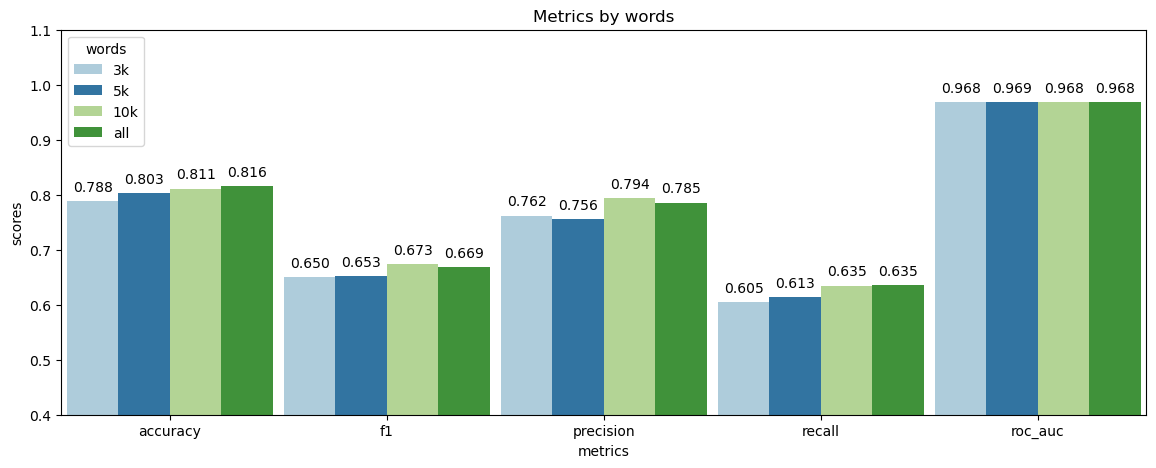

In [74]:
plt.figure(figsize=(14, 5))
plt.title('Metrics by words')

ax= sns.barplot(x='metrics',y='scores',hue='words',data=data_by_words_metrics_lr,  palette='Paired', width=0.95)

plt.ylim(0.4, 1.1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x()+p.get_width()/2.,\
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

📑 LogisticRegression의 경우 다른 Metrics별로 Vocabulary size 성능을 보았다
- Accuracy는 Vocabulary size가 커져 `all`인 경우 성능이 가장 좋았다. 
- F1-score,  precision는 `10K`일때 근소한 차이로 가장 좋았다. 
- recall에서는 10k와 all일때 둘다 좋았다.  

### 4.2.2 Metrics 별 사전 사이즈 비교 (Voting)

In [141]:
# 모델을 고정하고 words별 다른 metrics을 보자
columns = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc', 'words']
org_data_vo= df[df['model']=='Voting'][columns]
data_by_words_metrics_vo = org_data_vo.melt(id_vars='words', var_name='metrics', value_name='scores')

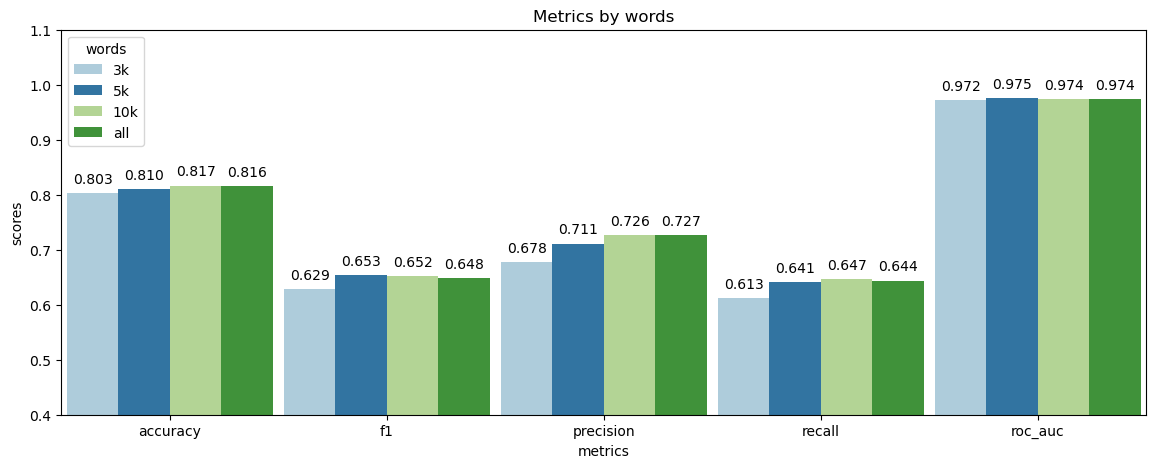

In [142]:
plt.figure(figsize=(14, 5))
plt.title('Metrics by words')

ax= sns.barplot(x='metrics',y='scores',hue='words',data=data_by_words_metrics_vo,  palette='Paired', width=0.95)

plt.ylim(0.4, 1.1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x()+p.get_width()/2.,\
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

📑 Voting 모델에서는 Metrics별로 큰 차이는 없어 보이지만, 굳이 가장 좋은 성능의 사전 사이즈를 꼽는다면 `10K`가 가장 좋다고 할 수 있다. 
- accuracy, recall은 10k가 근소한 차이로 좋다. 
- F1-score은 5k 좋은 성능을 보였다.
- precision에서는 all일때 좋았다.
<br><br>
#### 🧐 결론적으로 `가장 좋은 Vocabulary size는 10K`라고 보여진다. 
- LogisticRegression과 Voting 모델 모두에서, 10K가 근소한 차이지만 비교를 하자면, `10K가 좋은 성능`을 보여주었다. 


## 4.3 어떤 모델이 가장 좋은 성능인가?

### 4.3.1 모델별 F1 score 비교

가장 성능이 좋은 10K 사전을 기준으로 모든 모델의 f1 score 구해보자. 

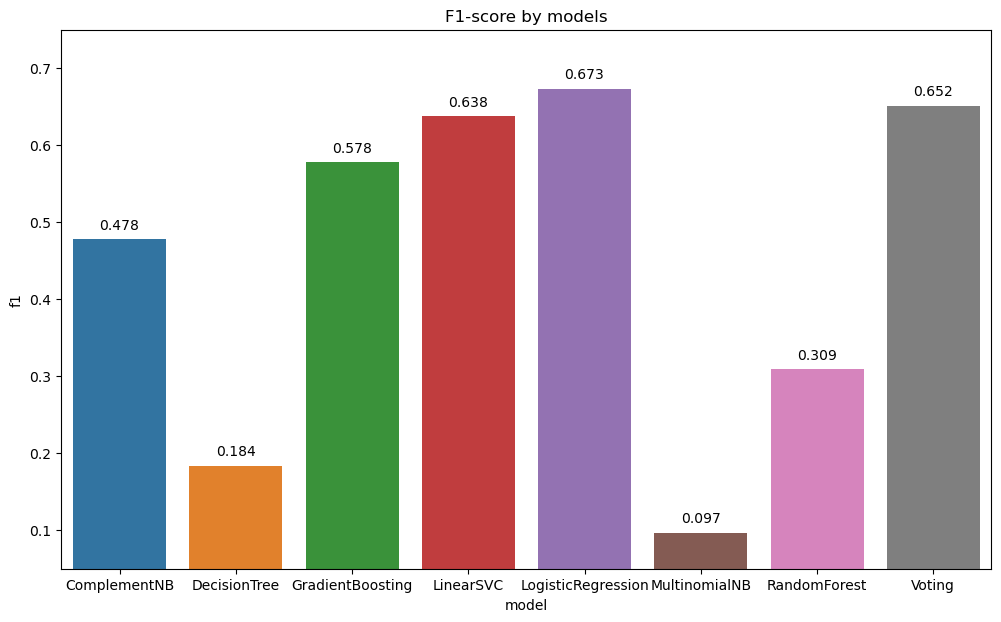

In [78]:
data_by_model_f1 = df[df['words']=='10k'][['model','f1']]

plt.figure(figsize=(12, 7))
plt.title('F1-score by models')
ax = sns.barplot(x='model', y='f1', data=data_by_model_f1)
plt.ylim(0.05, 0.75)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x()+p.get_width()/2.,\
        p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

📑 사전 사이즈 10k(10000개)기준으로 모델별 F1-score를 확인해 보면 가장 좋은 모델이 `LogisticRegression`이 가장 놓은 점수를 보이고 있다. 

### 4.3.2 voca size에 따른 모델별 성능 추이 비교

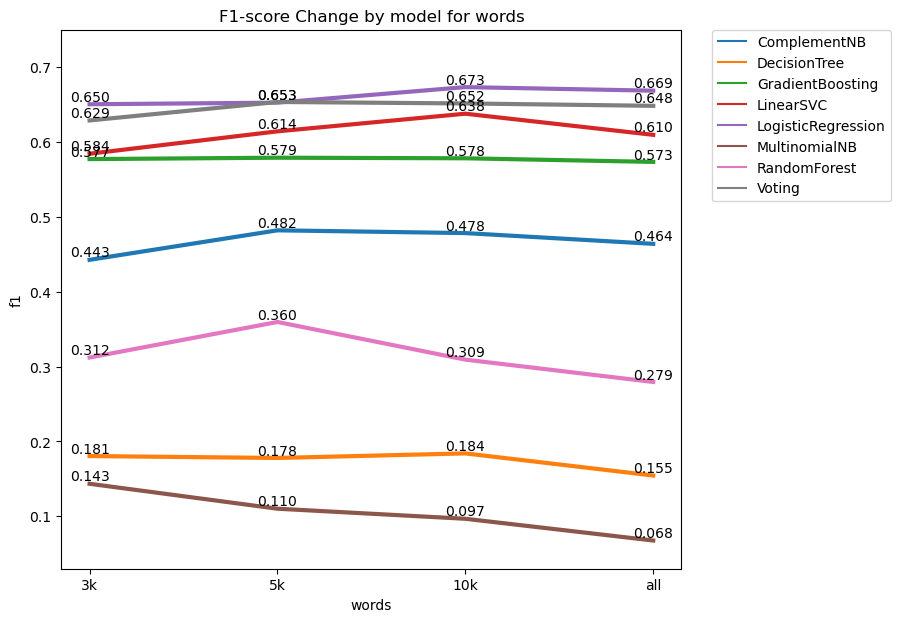

In [81]:
data_by_words_f1 = df[['words','model','f1']]

plt.figure(figsize=(8, 7))
plt.title('F1-score Change by model for words')

ax = sns.lineplot(x='words', y='f1', hue='model', data=data_by_words_f1, sort=False, linewidth=3)

plt.ylim(0.03, 0.75)

for line in ax.lines:
    x_data = line.get_xdata()
    y_data = line.get_ydata()
    for i in range(len(x_data)):
        plt.text(x_data[i], y_data[i], f'{y_data[i]:.3f}', ha='center', va='bottom')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

📑모델 알고리즘에 기반하여 분석하면, 
- __`ComplementNB > MultinomialNB`__     MultinomialNB 모델 보다 불균형한 데이타에 강한 ComplementNB가 확실히 좋은 성능을 보인다. 
- __`GradientBoosting > RandomForest > DecisionTree`__ DecisionTree보다 여러개의 Tree를 사용하는 RandomForest 성능이 좋고,  여러 결정 트리를 앙상블 시키는 GradientBoosting이 더 좋은 성능을 보인다. 

#### 🧐결론적으로 본 데이타를 가지고 머신 러닝 classification 문제를 해결하기 위한 가장 좋은 모델은 `LogisticRegression 모델`라고 할 수 있다.
- Vocabulary Size 변화를 기준으로 보면 LogisticRegression 모델이 F1-score 기준으로 가장 높은 점수를 유지하고 있음을 알 수 있다. 

 


#### 머신러닝 Model for Classification
| 알고리즘               | 특징                                                 | 장점                                                                                     | 단점                                                                            |
| ------------------ | -------------------------------------------------- | -------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------- |
| ComplementNB       | \- Naive Bayes의 변형 알고리즘으로, 클래스 불균형 문제에 효과적         | \- 클래스 불균형 문제에 강함<br>- 작은 클래스에 대해 잘 동작<br>- 낮은 메모리 사용량과 빠른 학습 속도                       | \- 독립 가정에 의존하며, 실제 데이터에는 적합하지 않을 수 있음                                         |
| DecisionTree       | \- 특징 공간을 분할하여 데이터를 분류하는 알고리즘                      | \- 해석하기 쉽고 직관적으로 이해할 수 있음<br>- 범주형 데이터와 연속형 데이터 모두에 대해 처리 가능<br>- 이상치에 민감하지 않음         | \- 과적합될 가능성이 큼<br>- 특정 데이터에 과도하게 의존할 수 있어 일반화 능력이 부족할 수 있음                    |
| GradientBoosting   | \- 약한 학습기를 순차적으로 학습하여 강한 학습기를 구성하는 부스팅 앙상블 기법      | \- 다양한 종류의 데이터에 잘 적용됨<br>- 과적합에 강함<br>- 예측 성능이 뛰어나며, 이상치에 민감하지 않음                      | \- 모델 학습 및 예측에 시간이 오래 걸릴 수 있음<br>- 모델의 복잡성으로 인해 해석하기 어려울 수 있음                 |
| LinearSVC          | \- 선형 분류를 위한 서포트 벡터 머신(SVM)의 한 종류                  | \- 높은 차원의 데이터에서 잘 동작함<br>- 메모리 사용이 효율적임                                                | \- 다중 클래스 분류에 직접 적용하기 어려울 수 있음<br>- 데이터의 스케일에 민감할 수 있음                        |
| LogisticRegression | \- 범주형 종속 변수와 하나 이상의 독립 변수 간의 관계를 모델링하는 알고리즘       | \- 해석하기 쉽고, 계수의 중요도를 해석할 수 있음<br>- 이진 분류 및 다중 클래스 분류에 효과적                              | \- 선형 결정 경계만 모델링할 수 있음<br>- 비선형 문제에 대해서는 성능이 제한될 수 있음                         |
| MultinomialNB      | \- 다중 클래스 분류를 위한 Naive Bayes의 변형 알고리즘, 주로 NLP에 사용됨 | \- 간단하고 빠른 학습 속도<br>- 작은 데이터셋에서도 잘 동작함<br>- 희소한 데이터에 효과적                               | \- 독립 가정을 가지고 있음<br>- 실제 데이터에서는 이 가정이 맞지 않을 수 있음<br>- 종속 변수 간의 상호 작용을 고려하지 않음 |
| RandomForest       | \- 의사결정 트리의 앙상블 모델로, 다양한 의사결정 트리를 생성하여 예측을 결합함     | \- 과적합에 강함<br>- 다양한 데이터 유형을 처리할 수 있음<br>- 변수의 중요도를 추정할 수 있음<br>- 수치형 및 범주형 특징 모두 처리 가능 | \- 해석하기 어려움<br>- 모델의 크기와 복잡성으로 인해 학습 및 예측에 시간이 오래 걸릴 수 있음                     |
| Voting             | \- 다양한 분류기의 예측 결과를 조합하여 최종 예측을 수행하는 앙상블 기법         | \- 다수결 투표나 가중 평균을 통해 안정적인 예측을 할 수 있음<br>- 개별 분류기보다 전체 앙상블의 성능을 향상시킬 수 있음               | \- 개별 분류기의 성능에 의존함<br>- 해석력이 제한적일 수 있음                                        |


-from chatGPT-

# 5.Deep Learning Model 구현


- 가장 성능이 좋았던 words 10k를 대상으로 Deep learnging 모델을 만들어 보자. 
(동일 데이타, 동일 전처리를 기반으로 )

## 5.1 Data Load

In [35]:
tfidfv_data = data_load(num_words=10000)

X_train= tfidfv_data['X_train'].toarray()
y_train = tfidfv_data['y_train']
X_test = tfidfv_data['X_test'].toarray()
y_test = tfidfv_data['y_test']

X_train_dense = tfidfv_data['X_train'].todense()
X_test_dense = tfidfv_data['X_test'].todense()


- tfidfv_data['X_train'] 데이타는 scipy.sparse._csr.csr_matrix 타입으로 sparse matrix이다. 
- 이것을 그대로 사용할 수 없어서 toarray() 함수를 사용해서 numpy.ndarray 로 바꿔주거나
- todense()를 사용해서 numpy.matrix으로 바꾸어 sparse matrix 아닌 distribution matrix로 바꿔주어야 한다. 


In [36]:
print('X_train.shape:',X_train.shape)
print('y_train.shape:',y_train.shape)
print('X_test.shape:',X_test.shape)
print('y_test.shape:',y_test.shape)
print('X_train_dense.shape:',X_train_dense.shape)
print('X_test_dense.shape:',X_test_dense.shape)

X_train.shape: (8982, 9670)
y_train.shape: (8982,)
X_test.shape: (2246, 9670)
y_test.shape: (2246,)
X_train_dense.shape: (8982, 9670)
X_test_dense.shape: (2246, 9670)


In [37]:
X_train[2]

array([0.        , 0.08655827, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [38]:
#패딩처리하고 텐서 객체로 바꿔주고 
# maxlen = 100
                                             

# X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
#                                                     value=0,
#                                                     padding='post', # 혹은 'pre'
#                                                     maxlen=maxlen)

# X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
#                                                     value= 0,
#                                                     padding='post', # 혹은 'pre'
#                                                     maxlen=maxlen)


In [39]:
vocab_size = 10000
word_vector_dim = 100  

## 5.2 DeepLearning 공통함수

In [ ]:
# 훈련개시
def model_training(model, epochs):
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience = 2
        )
    ]
    model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy',])
                    
    epochs=epochs  
    
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=64,
                        validation_split=0.2,
                        callbacks = callbacks,
                        verbose=1)
    return history

In [ ]:
def show_history(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()

## 5.3 RNN-LSTM Model

In [40]:
from tensorflow import keras

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model_LSTM.add(keras.layers.LSTM(128))
model_LSTM.add(keras.layers.Dense(128, activation='relu'))  
model_LSTM.add(keras.layers.Dense(64, activation='relu')) 
model_LSTM.add(keras.layers.Dense(64, activation='relu'))  
model_LSTM.add(keras.layers.Dense(46, activation='softmax'))  

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 46)                2990      
                                                                 
Total params: 1,149,166
Trainable params: 1,149,166
Non-

In [43]:
history_LSTM = model_training(model_LSTM,20)

Epoch 1/20
113/113 [==============================] - 63s 525ms/step - loss: 2.5809 - accuracy: 0.3441 - val_loss: 2.4312 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 58s 514ms/step - loss: 2.4165 - accuracy: 0.3534 - val_loss: 2.4214 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 59s 520ms/step - loss: 2.4159 - accuracy: 0.3534 - val_loss: 2.4104 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 57s 508ms/step - loss: 2.4142 - accuracy: 0.3534 - val_loss: 2.4304 - val_accuracy: 0.3450
Epoch 5/20
113/113 [==============================] - 59s 522ms/step - loss: 2.4119 - accuracy: 0.3534 - val_loss: 2.4218 - val_accuracy: 0.3450


In [44]:
Scores = model_LSTM.evaluate(X_test_dense, y_test, verbose=1)
print('Test loss:', Scores[0])
print('Test accuracy:', Scores[1])

71/71 [==============================] - 9s 130ms/step - loss: 2.4336 - accuracy: 0.3620
Test loss: 2.4335739612579346
Test accuracy: 0.36197686195373535


📑RNN-LSTM 모델로 학습했지만, 학습이 잘 이루어지지 않고, Accuracy도 0.36으로 낮다

In [46]:
X_train_dense.shape, X_train.shape, y_train.shape

((8982, 9670), (8982, 9670), (8982,))

## 5.4 MLP 모델

In [47]:
from tensorflow.keras import regularizers
from keras.layers import Dropout

In [136]:
print(X_train_dense.shape[1])

9670


In [93]:

model_dense = tf.keras.Sequential()
# model_dense.add(tf.keras.layers.Embedding(vocab_size, 
#                                     word_vector_dim, 
#                                     input_shape=(None,)
#                                     ))

model_dense.add(tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)))  
model_dense.add(tf.keras.layers.Dense(256, activation='relu')) 
model_dense.add(tf.keras.layers.Dense(128, activation='relu')) 
model_dense.add(Dropout(0.2))  
model_dense.add(tf.keras.layers.Dense(128, activation='relu')) 
model_dense.add(tf.keras.layers.Dense(64, activation='relu')) 
model_dense.add(Dropout(0.2))  
model_dense.add(tf.keras.layers.Dense(64, activation='relu'))  
model_dense.add(tf.keras.layers.Dense(46, activation='softmax'))  

model_dense.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               2475776   
                                                                 
 dense_25 (Dense)            (None, 245)               62965     
                                                                 
 dense_26 (Dense)            (None, 128)               31488     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               16512     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)               

In [94]:
history_dense = model_training(model_dense,20)

Epoch 1/20
113/113 [==============================] - 1s 7ms/step - loss: 2.1469 - accuracy: 0.4476 - val_loss: 1.5333 - val_accuracy: 0.6110
Epoch 2/20
113/113 [==============================] - 1s 6ms/step - loss: 1.3257 - accuracy: 0.6579 - val_loss: 1.2436 - val_accuracy: 0.7078
Epoch 3/20
113/113 [==============================] - 1s 6ms/step - loss: 0.9356 - accuracy: 0.7567 - val_loss: 1.2128 - val_accuracy: 0.7390
Epoch 4/20
113/113 [==============================] - 1s 6ms/step - loss: 0.6669 - accuracy: 0.8160 - val_loss: 1.1718 - val_accuracy: 0.7679
Epoch 5/20
113/113 [==============================] - 1s 6ms/step - loss: 0.5244 - accuracy: 0.8527 - val_loss: 1.2227 - val_accuracy: 0.7679
Epoch 6/20
113/113 [==============================] - 1s 6ms/step - loss: 0.4076 - accuracy: 0.8810 - val_loss: 1.2423 - val_accuracy: 0.7702


In [95]:
Scores = model_dense.evaluate(X_test_dense, y_test, verbose=1)
print('Test loss:', Scores[0])
print('Test accuracy:', Scores[1])

71/71 [==============================] - 0s 3ms/step - loss: 1.3111 - accuracy: 0.7654
Test loss: 1.311055064201355
Test accuracy: 0.7653606534004211


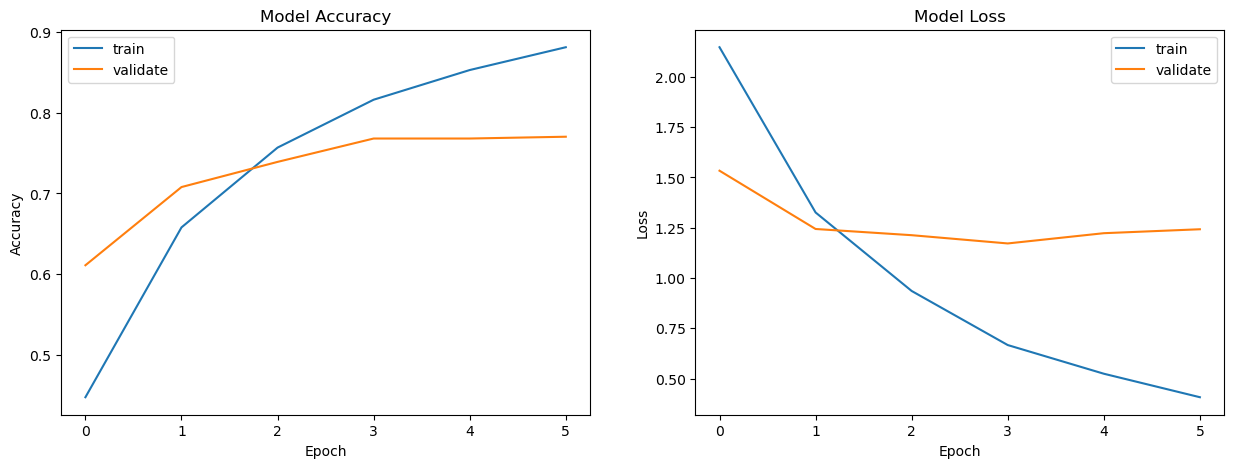

In [96]:
show_history(history_dense)

📑 epochs 4부터 과대적합이 발생하며 학습이 원할하게 이루어지지 않음을 알수 있다.    
Test data에 대한 Accuracy는 0.77 이다.


## 5.5. CNN 모델

In [114]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, 
                                    word_vector_dim, 
                                    input_shape=(None,)
                                    ))


model_cnn.add(tf.keras.layers.Conv1D(128,7, padding='valid', activation='relu', strides=1))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5)) 

model_cnn.add(tf.keras.layers.Dense(46, activation='relu')) 
model_cnn.add(Dropout(0.5)) 
model_cnn.add(tf.keras.layers.Dense(46, activation='softmax'))  

model_cnn.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 128)         28800     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 46)                5934      
                                                                 
 dropout_25 (Dropout)        (None, 46)                0         
                                                     

In [115]:
history_cnn = model_training(model_cnn,20)

Epoch 1/20
113/113 [==============================] - 13s 114ms/step - loss: 3.0023 - accuracy: 0.2639 - val_loss: 2.4262 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 12s 109ms/step - loss: 2.6004 - accuracy: 0.3299 - val_loss: 2.4092 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 15s 135ms/step - loss: 2.5372 - accuracy: 0.3371 - val_loss: 2.4393 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 13s 114ms/step - loss: 2.5067 - accuracy: 0.3443 - val_loss: 2.4348 - val_accuracy: 0.3450


In [116]:
Scores = model_cnn.evaluate(X_test_dense, y_test, verbose=1)
print('Test loss:', Scores[0])
print('Test accuracy:', Scores[1])

71/71 [==============================] - 1s 17ms/step - loss: 2.4411 - accuracy: 0.3620
Test loss: 2.4411137104034424
Test accuracy: 0.36197686195373535


📑 CNN 1D 모델을 구현해 봤는데, accuracy 0.36이고, val_accuracy도 변화가 없는 것으로 보아 제대로 학습이 이루어지지 않은 것 같다.

## 5.6 MLP 모델 (with regularization)

In [146]:
from tensorflow.keras import regularizers

model_dense_re = tf.keras.Sequential()

model_dense_re.add(tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train_dense.shape[1],),\
   kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model_dense_re.add(Dropout(0.7))  
model_dense_re.add(Dropout(0.7))  
model_dense_re.add(tf.keras.layers.Dense(46, activation='softmax'))  
model_dense_re.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 512)               4951552   
                                                                 
 dropout_26 (Dropout)        (None, 512)               0         
                                                                 
 dropout_27 (Dropout)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 46)                23598     
                                                                 
Total params: 4,975,150
Trainable params: 4,975,150
Non-trainable params: 0
_________________________________________________________________


In [107]:
history_dense_re = model_training(model_dense_re,40)

Epoch 1/40
113/113 [==============================] - 1s 9ms/step - loss: 2.7014 - accuracy: 0.4573 - val_loss: 1.8975 - val_accuracy: 0.5598
Epoch 2/40
113/113 [==============================] - 1s 7ms/step - loss: 1.8508 - accuracy: 0.5978 - val_loss: 1.6888 - val_accuracy: 0.6889
Epoch 3/40
113/113 [==============================] - 1s 7ms/step - loss: 1.6934 - accuracy: 0.6699 - val_loss: 1.5853 - val_accuracy: 0.7151
Epoch 4/40
113/113 [==============================] - 1s 7ms/step - loss: 1.6013 - accuracy: 0.6953 - val_loss: 1.5186 - val_accuracy: 0.7279
Epoch 5/40
113/113 [==============================] - 1s 7ms/step - loss: 1.5401 - accuracy: 0.7147 - val_loss: 1.4761 - val_accuracy: 0.7485
Epoch 6/40
113/113 [==============================] - 1s 7ms/step - loss: 1.4903 - accuracy: 0.7383 - val_loss: 1.4459 - val_accuracy: 0.7602
Epoch 7/40
113/113 [==============================] - 1s 7ms/step - loss: 1.4491 - accuracy: 0.7492 - val_loss: 1.4148 - val_accuracy: 0.7707
Epoch 

In [143]:
Scores = model_dense_re.evaluate(X_test_dense, y_test, verbose=1)
print('Test loss:', Scores[0])
print('Test accuracy:', Scores[1])

71/71 [==============================] - 0s 4ms/step - loss: 1.3140 - accuracy: 0.8077
Test loss: 1.3140376806259155
Test accuracy: 0.8076580762863159


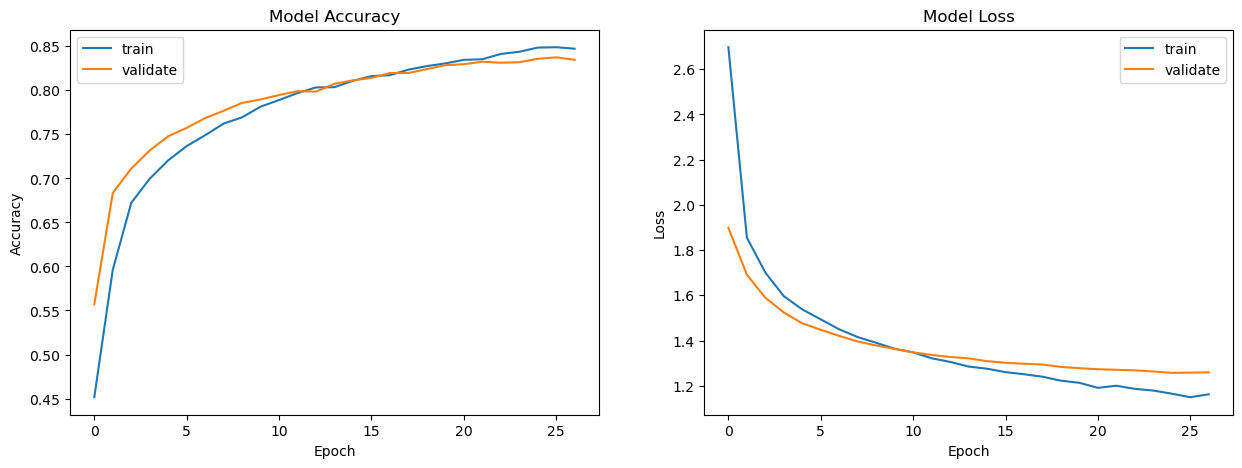

In [103]:
show_history(history_dense_re)

In [165]:
# F1 Score 구하기
import tensorflow_addons.metrics  as tfam
f1 = tfam.F1Score(num_classes=46, average='macro')

y_true = tf.keras.utils.to_categorical(y_test)
y_pred = model_dense_re.predict(X_test_dense)

f1.update_state(y_true, y_pred)
print('F1 Score is: ', f1.result().numpy())

71/71 [==============================] - 0s 1ms/step
F1 Score is:  0.54093766


📑F1-score를 구하기 위해 tensorflow_addons을 설치해야 한다. 

#### F1-score 평균 계산 방식의 차이
| 평균 방법    | 특징                                                                       | 장점                                     | 단점                                                        |
| -------- | ------------------------------------------------------------------------ | -------------------------------------- | --------------------------------------------------------- |
| Micro    | 모든 클래스의 FP, FN, TP의 총합을 계산한 후 F1 점수를 계산합니다.                              | 클래스 불균형에 강하며, 전체적인 성능을 평가합니다.          | 개별 클래스의 성능을 무시하므로, 소수 클래스의 성능이 중요한 경우 적합하지 않을 수 있습니다.     |
| Macro    | 각 클래스에 대한 F1 점수를 독립적으로 계산하고, 이들의 평균을 계산합니다.                              | 모든 클래스를 동일하게 취급하므로, 모든 클래스의 성능을 고려합니다. | 클래스 불균형에 약하므로, 불균형한 데이터셋에서는 전체적인 성능을 정확하게 반영하지 못할 수 있습니다. |
| Weighted | 각 클래스에 대한 F1 점수를 계산하고, 이들의 평균을 계산합니다. 그러나 이 평균은 각 클래스의 샘플 수로 가중치가 적용됩니다. | 클래스 불균형을 고려하면서 각 클래스를 독립적으로 평가합니다.     | 가중치가 적용되므로, 소수 클래스의 성능이 과소평가될 수 있습니다.                     |

-from chatGPT-

기타 참고 자료

In [122]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, model_dense_re.predict(X_test_dense).argmax(axis=1)))

71/71 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.69      0.86      0.77       105
           2       0.81      0.65      0.72        20
           3       0.93      0.94      0.93       813
           4       0.79      0.91      0.85       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.67      0.63      0.65        38
           9       0.81      0.88      0.85        25
          10       0.89      0.83      0.86        30
          11       0.65      0.82      0.73        83
          12       1.00      0.23      0.38        13
          13       0.58      0.68      0.63        37
          14       1.00      0.50      0.67         2
          15       0.00      0.00      0.00         9
          16       0.67     

71/71 [==============================] - 0s 2ms/step


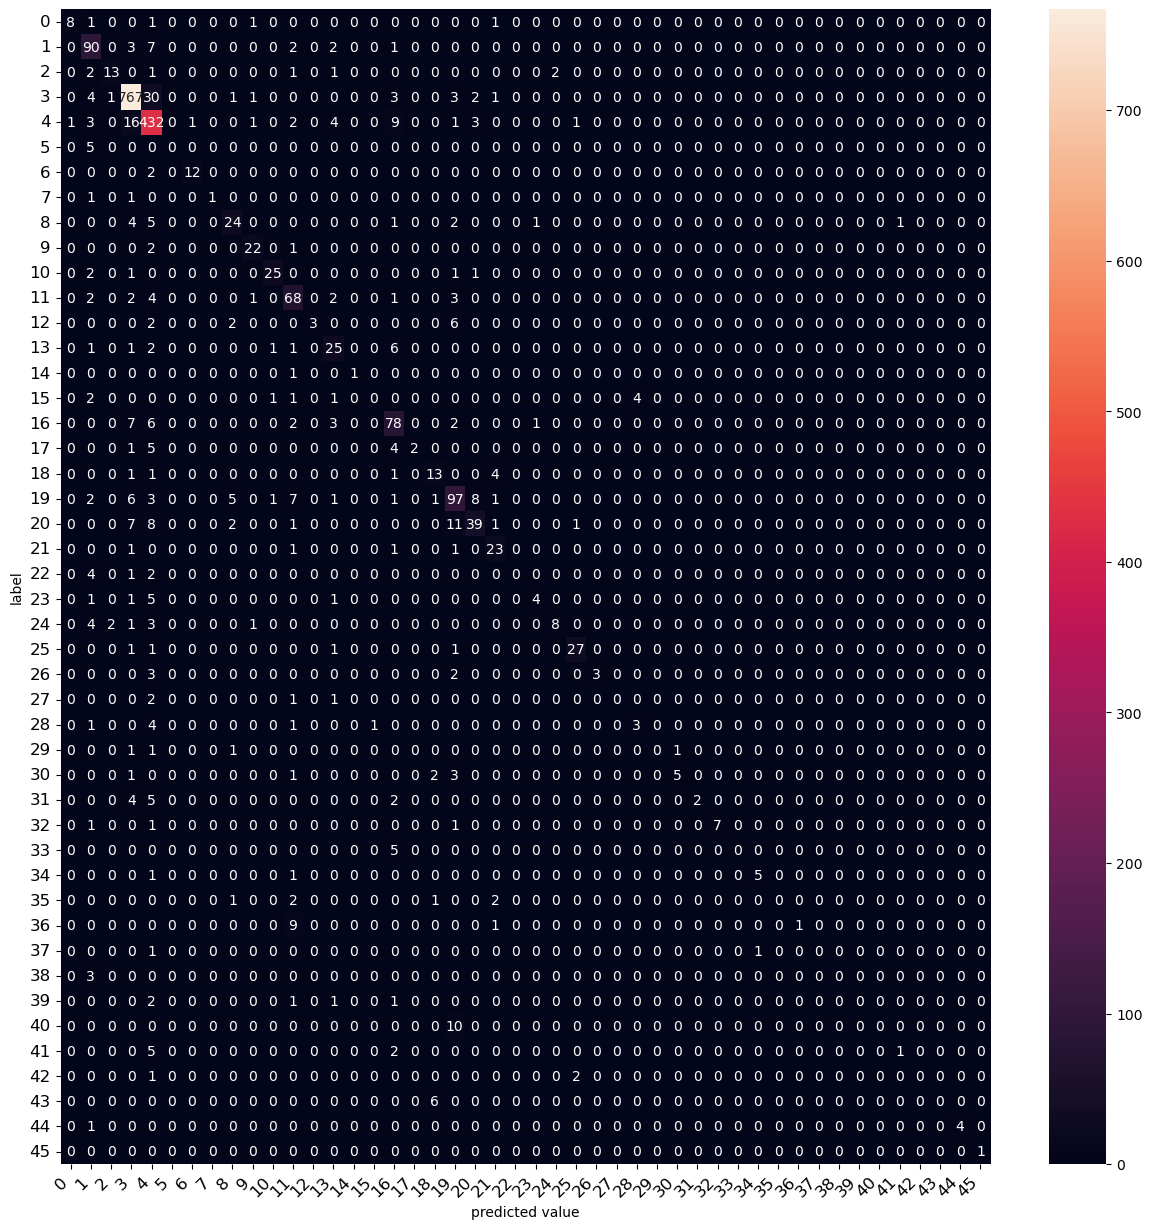

In [125]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test).argmax(axis=1)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(15,15))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')
    
graph_confusion_matrix(model_dense_re, X_test_dense, y_test)

# 6.뉴스 기사 분류에 대한 머신러닝과 딥러닝의 성능 비교 분석 

#### 분석 개요
| Data                  | Keras reuters                           |
| --------------------- | --------------------------------------- |
| Train data set        |  8982 개                                 |
| Test data set         | 2246 개                                  |
| 분류 class              |  46개                                    |
| vocabulary words size |  10K                                    |
| performance Metrics   |  Accuracy, F1 score (macro)                    |
| 머신러닝의 모델              |  Logistic Regression                    |
| 딥러닝 모델                |  MLP with regularization                |
| 데이타 셋의 특성             |  46개 클래스 중에서 3,4번에 데이타가 집중되어 이는 불균형 데이타 |

In [247]:
pef_dt= pd.DataFrame(data=[['DL', 0.80, 0.54]], columns=['model','accuracy','f1'])
pef_dt.loc[len(pef_dt)]= ['ML',0.81, 0.67]
pef_dt

,model,accuracy,f1
0,DL,0.80,0.54
1,ML,0.81,0.67


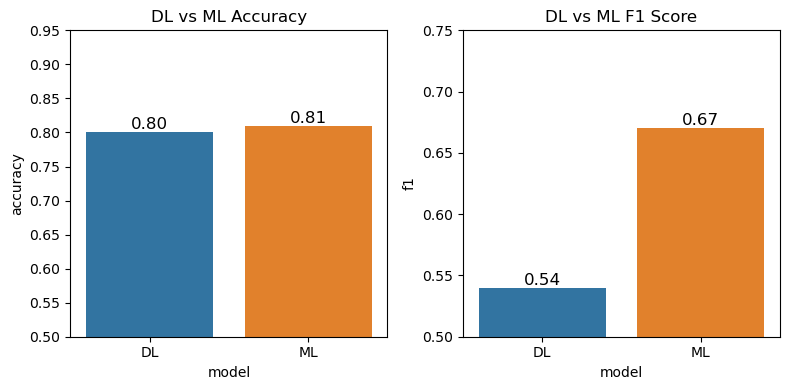

In [246]:
# 비교 그래프 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.barplot(x='model', y='accuracy', data=pef_dt, ax=ax1)
ax1.set_title('DL vs ML Accuracy')
ax1.set_ylim([0.5, 0.95])
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width() / 2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=12, ha='center', va='bottom')
    

sns.barplot(x='model', y='f1', data=pef_dt, ax=ax2)
ax2.set_title('DL vs ML F1 Score')
ax2.set_ylim([0.5, 0.75])
for p in ax2.patches:
    ax2.text(p.get_x() + p.get_width() / 2., p.get_height(), '{0:.2f}'.format(p.get_height()), 
            fontsize=12, ha='center', va='bottom')

plt.tight_layout()
plt.show()
    


📑 머신 러닝(ML) 데이타와 딥러닝(DL)데이타를 Accuracy와 F1-score를 기준으로 살펴보면, 
- ML이 Accuracy에서는 근소하게 앞섰지만, F1-score에서는 유의미한 차이로 높은 성능을 나타냈다.

- Why ML이 더 나은 성능을 보였을까?
- 이유는 데이타 양이  적었다. train data 8982 개, test data  2246개로 딥러닝에서 유의미한 학습을 진행하기에는
부족하다고 생각된다. 

#### 🧐 결론적으로 이번 데이타에서는 F1-score 기준으로 '머신러닝(ML)'이 좀 더 나은 성능을 보였다. 
- 머신러닝과 딥러닝 중에서 무조건 딥러닝이 더 좋은 기술이 아니라 데이타의 양, 특성, 해결할 과제에 따라 머신러닝으로도   
 좋은 성능과 결과를 나타낼 수 있다는 사실을 알았다.  


# 7.회고

- 머신러닝의 모델을 여러개 실행시키느라 vocabulary 1개 당 1시간 정도 걸렸다. 모두(4시간T.T)
- 모델을 실행하고 Metrics를 산출하는데 구조화된 접근이 필요해서 공통함수를 만들고, dict타입으로 반환해서 DataFrame에 넣었다. 
- 4시간이나 돌린 Metrics 결과를 나중에도 사용하고자 파일로 저장했더니 편리하게 사용할 수 있었다. 
- 딥러닝 모델을 찾고 구현해 봤는데 생각보다 성능이 많이 안나왔다. 
- 딥러닝 모델로 RNN-LSTM, MLP, CNN등을 시도해 보았는데, Tensor 차원을 맞추는 것이 쉽지 않았다. 
- 아직도 type이 많이 헷갈리고, 차원수도 헷갈려서 다시 봐야 할듯 한다. 

- 🎁도전1. 딥러닝에서 f1-score 구하기
마지막에 딥러닝에서도 f1-score내서 ML과 비교하려 했는데, sklearn.metrics에서 f1_score를 호출하니 에러가 났다. 
여러가지 방법을 찾다가 tensorflow addon을 설치하여 구할 수 있었다. 

- 🎁도전2. 아직도 어려운 visualization
아직도 나에게는 Dataframe과 plt, sns가 너무도 어렵다. 내가 보여주고 싶은 그래프가 촥촥 나오면 좋은데 그게 잘 안된다.
이번에 chatGPT에게 물어보며 그래프를 작성했다. 원하는 쿼리를 이렇게 시원시원하게 알려주다니 놀라웠다.
에러에 대한 메세지도 물어봤더니 함수명을 알려줘서 응용해서 수정했다. 
점점 편해지기는 하는데, 그냥 chatGPT에게 물어보면 되니, 점점 내 머리속에 넣는 일이 게을러지는 느낌이다. 

- 🎁도전3. 머신러닝 Metrics 데이타 
머신러닝의 여러 모델을 돌려서 얻은 Metrics의 데이타를 github에 올려둔다. 
https://github.com/billygogo/Aiffel_GD_NLP/blob/main/data/metrics.zip   
나의 하찮은 발자국이 누군가에게 디딤돌이 되기를 바라며.. 😉



## 참고자료

- 케라스 text 분류 cnn참고 https://keras.io/examples/nlp/text_classification_from_scratch/
- MLP 참고 https://www.kaggle.com/code/roblexnana/a-simple-reuters-news-classifier-in-keras-for-nlp/notebook
- tensorflow-addon https://bestkcs1234.tistory.com/61